In [87]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import pickle
import matplotlib
import re
from math import sqrt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import ttest_ind, ttest_1samp
import sys
sys.path.insert(0, './')
sys.path.insert(0, '../')
from analyze_icpms import *
from os.path import join

outputDir = 'output'


# Import ICP-MS Data

In [88]:
conc_file_names = ['conc_icpms_12_04_21.csv', 'conc_icpms_12_09_21.csv', 'conc_icpms_12_11_21.csv', 'conc_icpms_12_18_21.csv',
                   'conc_icpms_12_21_21.csv']
counts_file_names = ['counts_icpms_12_04_21.csv', 'counts_icpms_12_09_21.csv', 'counts_icpms_12_11_21.csv', 
                     'counts_icpms_12_18_21.csv', 'counts_icpms_12_21_21.csv']
conc_has_rsds = [False, True, True, True, True]
counts_has_rsds = [True, True, True, True, True]

inputDir = 'input'

samp_dics = []
cal_dics = []
counts_samp_dics = []
counts_cal_dics = []

for i in range(len(conc_file_names)):
    samp_dics.append(read_icpms_file(join(inputDir, conc_file_names[i]), conc_has_rsds[i]))
    cal_dics.append(read_cal_curve(join(inputDir,conc_file_names[i]), conc_has_rsds[i]))
    counts_samp_dics.append(read_icpms_file(join(inputDir, counts_file_names[i]), counts_has_rsds[i]))
    counts_cal_dics.append(read_cal_curve(join(inputDir, counts_file_names[i]), counts_has_rsds[i]))
    
# defines important parameters
rel_rees = ['139  La  [ No Gas ] ', '151  Eu  [ No Gas ] ', '172  Yb  [ No Gas ] ']
Rh_lab = '103  Rh ( ISTD )  [ No Gas ] '
adjust_by_Rh = True
scenario_labels = ['10-30', '10-60', '50-10', '50-30']
dil = 1 / 25
num_reps = 3

# strains for each round of data collection
strains = [['1327', '0625', '4410', '3385', '4114', '4685', 'wt', 'wtc1', 'wtc2', 'qwt'],
           ['1327t', '3385t', '4114t', '4685t', '1203', '3189', '3190', '3191', 'qwt2'],
           ['3192', '4100', '4103', '4104', '4105', '4106', '4112', '3695', '2592', '4255', 'qwt3'],
           ['3175', '4799', '3183', '0456', '0608', '3988', '3099', '2493', '3145', 'qwt4'],
           ['0625', '2493']]
all_strains = strains[0] + strains[1] + strains[2] + strains[3]

# Calculates Correction using Rh Internal Standard

In [89]:
# correction params: line fit
Rh_cor_params = [[], [], []]
for i in range(len(samp_dics)):
    
    # calculates percent off of calibration checks
    num_checks = 0
    all_keys = samp_dics[i].keys()
    for key in all_keys:
        if key[:9] == 'cal check':
            num_checks += 1
    indiv_perc_offs = [np.zeros(num_checks), np.zeros(num_checks), np.zeros(num_checks)]
    indiv_Rh_vals = np.zeros(num_checks)
    order = ['10', '25', '50', '100']
    idx = 0
    for j in range(num_checks):
        samp = 'cal check ' + order[idx % len(order)]
        if idx // len(order) > 0:
            samp = samp + ' #' + str(idx // len(order) + 1)
        curve_els = cal_dics[i][order[idx % len(order)]] 
        samp_els = samp_dics[i][samp]
        for k in range(len(rel_rees)):
            ree = rel_rees[k]
            samp_vals = get_uM_meas(samp_els, ree, 1)
            cal_vals = get_uM_meas(curve_els, ree, 1)
            indiv_perc_offs[k][j] = (samp_vals[0] - cal_vals[0]) / cal_vals[0]
        indiv_Rh_vals[j] = counts_samp_dics[i][samp][Rh_lab][0]
        idx += 1
    
    # calculates relationship between Rh measurement and calibration curve checks
    Rh_cor_params[0].append(np.polynomial.polynomial.Polynomial.fit(indiv_Rh_vals, indiv_perc_offs[0], 1).convert())
    Rh_cor_params[1].append(np.polynomial.polynomial.Polynomial.fit(indiv_Rh_vals, indiv_perc_offs[1], 1).convert())
    Rh_cor_params[2].append(np.polynomial.polynomial.Polynomial.fit(indiv_Rh_vals, indiv_perc_offs[2], 1).convert())

<IPython.core.display.Javascript object>


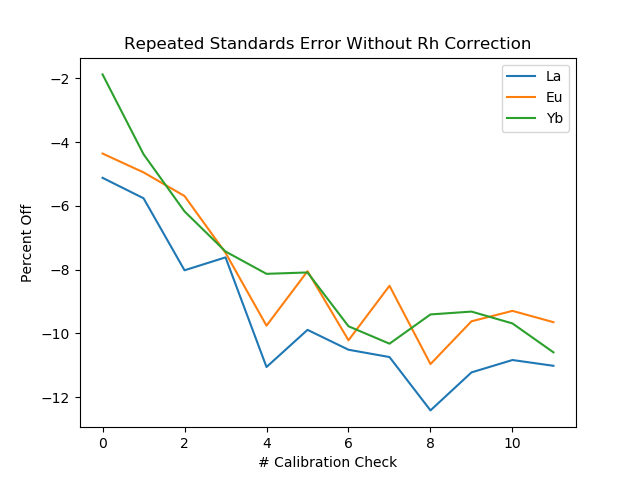

<IPython.core.display.Javascript object>


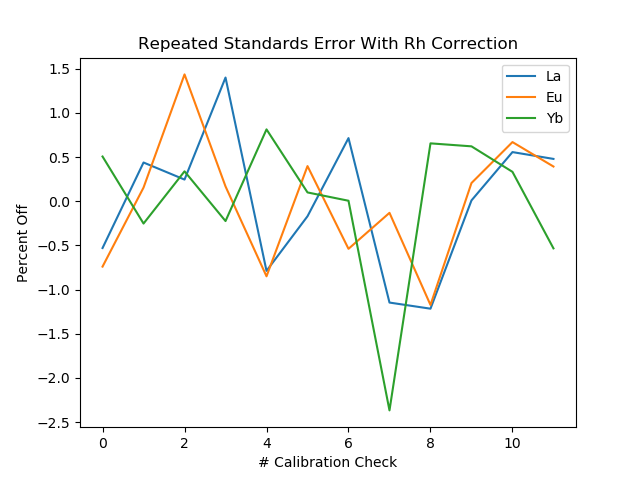

<IPython.core.display.Javascript object>


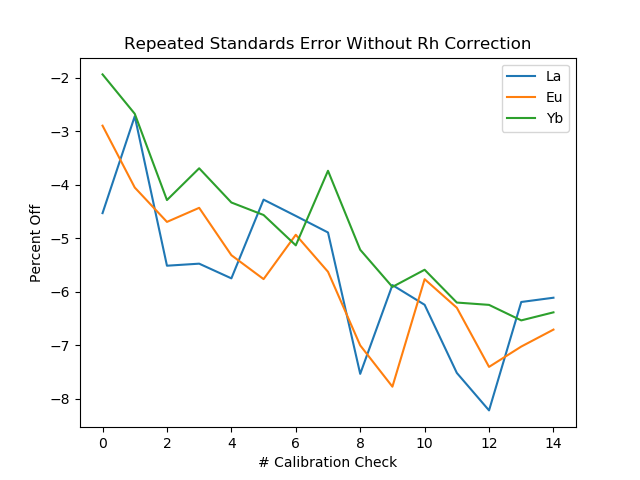

<IPython.core.display.Javascript object>


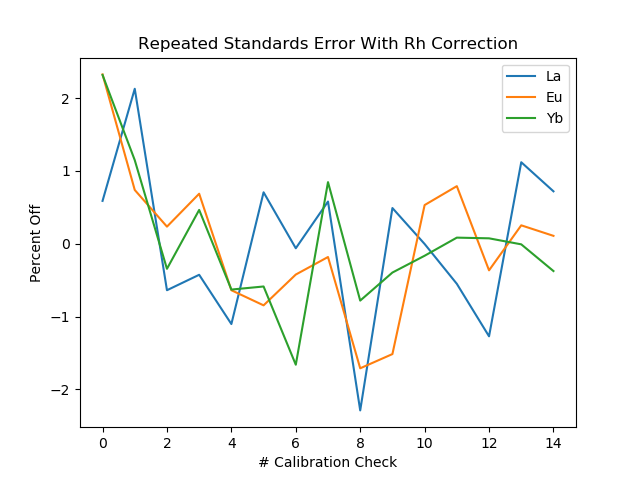

<IPython.core.display.Javascript object>


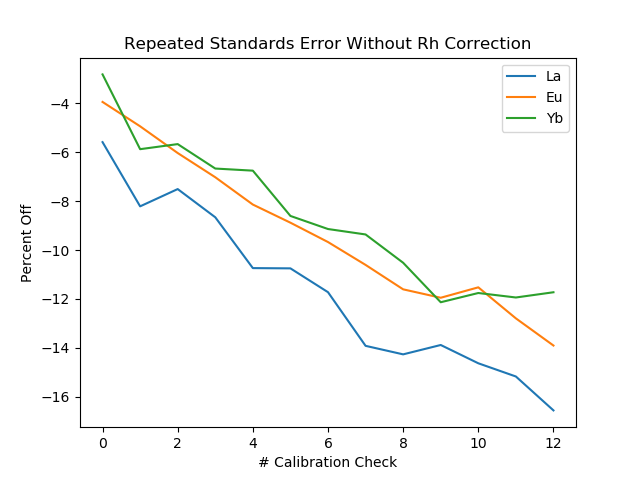

<IPython.core.display.Javascript object>


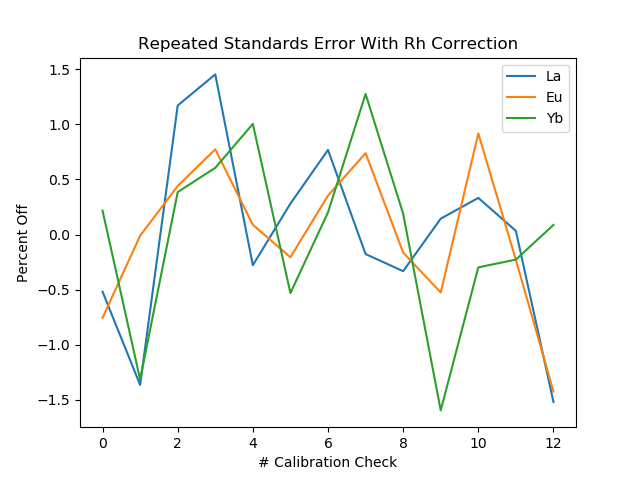

<IPython.core.display.Javascript object>


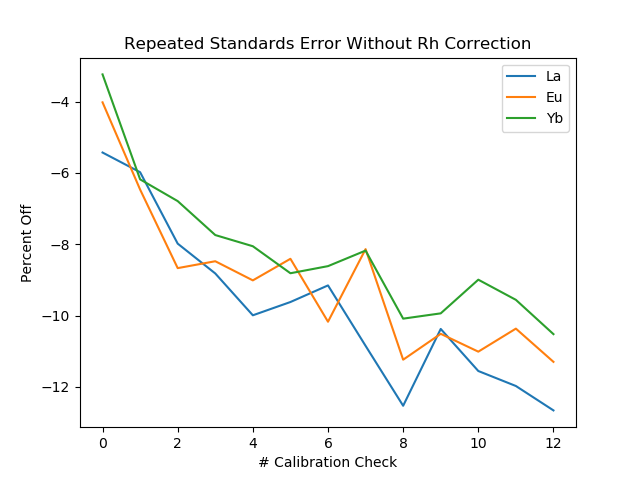

<IPython.core.display.Javascript object>


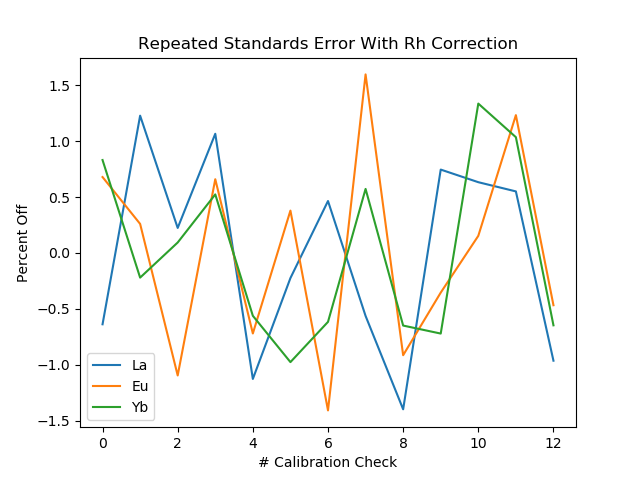

<IPython.core.display.Javascript object>


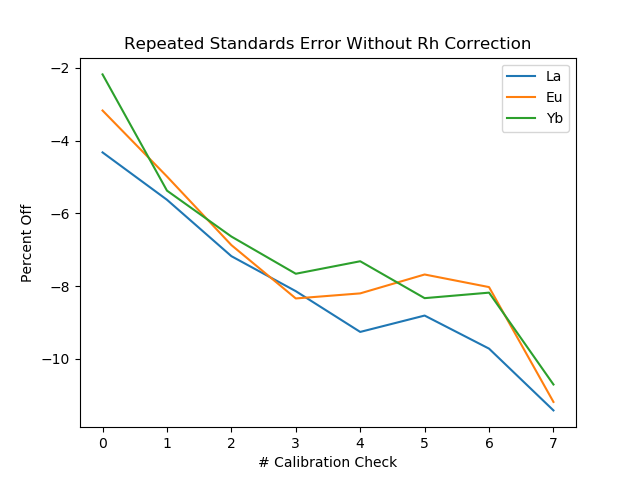

<IPython.core.display.Javascript object>


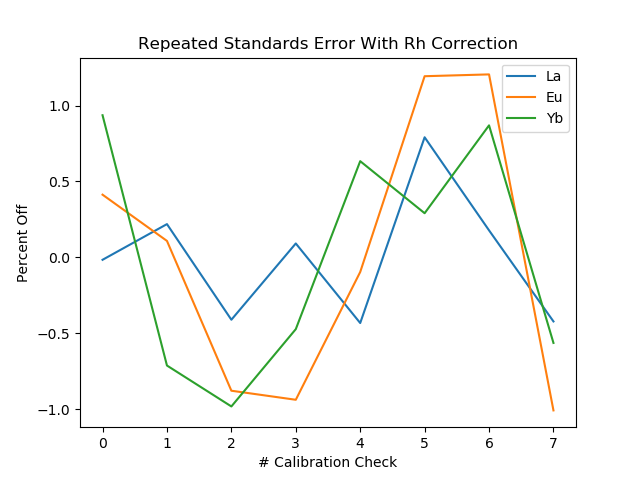

In [90]:
# plots before and after for each REE and each standard

for i in range(len(samp_dics)):
    
    # calculates percent off of calibration checks
    num_checks = 0
    all_keys = samp_dics[i].keys()
    for key in all_keys:
        if key[:9] == 'cal check':
            num_checks += 1
    indiv_perc_offs = [np.zeros(num_checks), np.zeros(num_checks), np.zeros(num_checks)]
    adj_perc_offs = [np.zeros(num_checks), np.zeros(num_checks), np.zeros(num_checks)]
    order = ['10', '25', '50', '100']
    idx = 0
    for j in range(num_checks):
        samp = 'cal check ' + order[idx % len(order)]
        if idx // len(order) > 0:
            samp = samp + ' #' + str(idx // len(order) + 1)
        curve_els = cal_dics[i][order[idx % len(order)]] 
        samp_els = samp_dics[i][samp]
        for k in range(len(rel_rees)):
            ree = rel_rees[k]
            samp_vals = get_uM_meas(samp_els, ree, 1)
            cal_vals = get_uM_meas(curve_els, ree, 1)
            indiv_perc_offs[k][j] = (samp_vals[0] - cal_vals[0]) / cal_vals[0]
            adj_perc_offs[k][j] = (samp_vals[0] / (1 + np.polynomial.polynomial.polyval(counts_samp_dics[i][samp][Rh_lab][0], 
                                                                    Rh_cor_params[k][i].coef)) - cal_vals[0]) / cal_vals[0]
        idx += 1
    plt.figure()
    for k in range(len(rel_rees)):
        plt.plot(indiv_perc_offs[k] * 100)
    plt.legend(['La', 'Eu', 'Yb'])
    plt.title('Repeated Standards Error Without Rh Correction')
    plt.xlabel('# Calibration Check')
    plt.ylabel('Percent Off')
    
    plt.figure()
    for k in range(len(rel_rees)):
        plt.plot(adj_perc_offs[k] * 100)
    plt.legend(['La', 'Eu', 'Yb'])
    plt.title('Repeated Standards Error With Rh Correction')
    plt.xlabel('# Calibration Check')
    plt.ylabel('Percent Off')

# Calculates and Plots Check Values

<IPython.core.display.Javascript object>


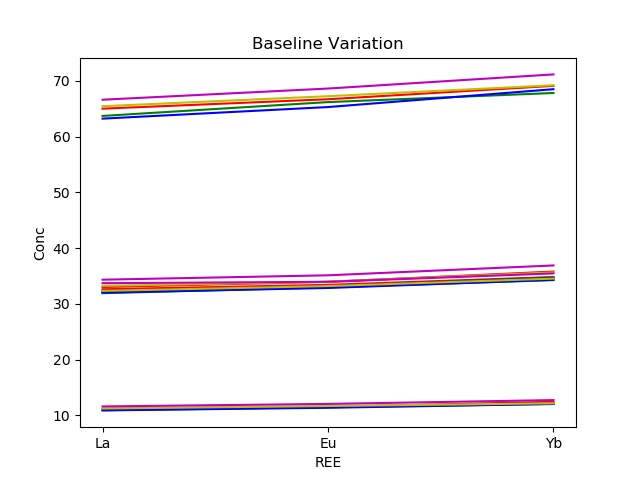

In [91]:
# calculates mean and standard deviation for checks

checks = []
colors = ['r', 'g', 'b', 'y', 'm']
check_labels = ['c', 'check2', 'check3', 'check4', 'c4r']

plt.figure()
for i in range(len(samp_dics)):

    check_vals = [np.zeros(3), np.zeros(3), np.zeros(3), np.zeros(3)] # 10-15, 10-45, 50-10, 50-30 (la, eu, and yb)

    # loops through alls
    for j in range(4): # looping through checks
        samp = check_labels[i] + '_' + scenario_labels[j]
        try:
            samp_els = samp_dics[i][samp]
        except Exception:
            print(samp_dics[i].keys())
        for k in range(len(rel_rees)): 
            ree = rel_rees[k]
            vals = get_uM_meas(samp_els, ree, dil)
            mean_val = vals[0]
            if adjust_by_Rh:
                mean_val = mean_val / (1 + np.polynomial.polynomial.polyval
                                       (counts_samp_dics[i][samp][Rh_lab][0], Rh_cor_params[k][i].coef))
            check_vals[j][k] = mean_val
        plt.plot([0,1,2], check_vals[j], color = colors[i])
    
    checks.append(check_vals)

plt.xticks([0,1,2], ['La', 'Eu', 'Yb'])
plt.xlabel('REE')
plt.ylabel('Conc')
plt.title('Baseline Variation')
checks[-1] = checks[-2]

# Extract REE Information for each Strain

In [92]:
# calculates free REE, bound REE, Kds for each strain

free_dic = {}
bound_dic = {}
Kd_dic = {}

# creates arrays for each strain
for s in range(len(all_strains)):
    free_dic[all_strains[s]] = np.zeros((len(scenario_labels), num_reps, len(rel_rees)))
    bound_dic[all_strains[s]] = np.zeros((len(scenario_labels), num_reps, len(rel_rees)))
    Kd_dic[all_strains[s]] = np.zeros((len(scenario_labels), num_reps, len(rel_rees)))
for i in range(len(samp_dics)):
    for s in range(len(strains[i])): # looping through strains in the data set
        for j in range(len(scenario_labels)): # looping through scenarios
            for r in range(num_reps): # looping through biological replicates
                samp = strains[i][s] + '_' + str(r+1) + '_' + scenario_labels[j]
                if samp in samp_dics[i]:
                    samp_els = samp_dics[i][samp]
                    for k in range(len(rel_rees)): 
                        ree = rel_rees[k]
                        vals = get_uM_meas(samp_els, ree, dil)
                        mean_val = vals[0]

                        if adjust_by_Rh:
                            mean_val = mean_val / (1 + np.polynomial.polynomial.polyval
                                           (counts_samp_dics[i][samp][Rh_lab][0], Rh_cor_params[k][i].coef))
                        free_dic[strains[i][s]][j][r][k] = mean_val
                        bound_dic[strains[i][s]][j][r][k] = checks[i][j][k] - mean_val
                        Kd_dic[strains[i][s]][j][r][k] = (checks[i][j][k] - mean_val) / mean_val

# Extracts WT OD Data

In [93]:
ODs = [0.2, 0.4, 0.6, 0.8, 1.2, 1.6, 2.0, 2.4]
free_OD_data = np.zeros((len(ODs), len(scenario_labels), len(rel_rees)))
bound_OD_data = np.zeros((len(ODs), len(scenario_labels), len(rel_rees)))
Kd_OD_data = np.zeros((len(ODs), len(scenario_labels), len(rel_rees)))

for s in range(len(ODs)):  
    # loops through all scenarios
    for j in range(len(scenario_labels)): # looping through scenarios
        samp = scenario_labels[j] + '_2_d' + str(s + 1)
        samp_els = samp_dics[-1][samp]
        for k in range(len(rel_rees)): 
            ree = rel_rees[k]
            vals = get_uM_meas(samp_els, ree, dil)
            mean_val = vals[0]

            if adjust_by_Rh:
                mean_val = mean_val / (1 + np.polynomial.polynomial.polyval
                               (counts_samp_dics[i][samp][Rh_lab][0], Rh_cor_params[k][i].coef))
            free_OD_data[s][j][k] = mean_val
            bound_OD_data[s][j][k] = checks[-1][j][k] - mean_val
            Kd_OD_data[s][j][k] = (checks[-1][j][k] - mean_val) / mean_val

# Miscellaneous Figures Highlighting Other Stuff

In [94]:
figureSize = (3.25,2)

<IPython.core.display.Javascript object>


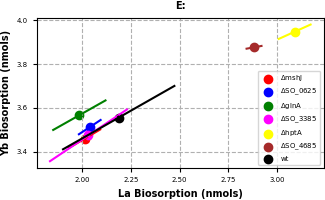

In [95]:
# compare non transposon mutants for each scenario

clean_strains = ['4114', '0625', '4410', '3385', '1327', '4685', 'wt']
clean_strain_labels = ['$\Delta$mshJ', '$\Delta$SO_0625', '$\Delta$glnA', '$\Delta$SO_3385', 
                       '$\Delta$hptA', '$\Delta$SO_4685', 'wt']
scen_labs = ['LL', 'LH', 'HL', 'HH']

# attempt #2: compare bound conc for each REE to total conc
rees = ['La', 'Eu', 'Yb']
sum_start = 0
sum_end = 1
c = 0.35
colors = ['red', 'blue', 'green', 'magenta', 'yellow', 'brown', 'black']
k = 2
j = 2

fig = plt.figure(figsize=figureSize)
ax = fig.gca()


for s in range(len(clean_strains)):
    strain = clean_strains[s]
    err1_xs, err1_ys, err2_xs, err2_ys = max_var_analysis(np.sum(bound_dic[strain][j,:,sum_start:sum_end],axis=1)*c, 
                                                          bound_dic[strain][j,:,k]*c)

    p = plt.scatter(np.mean(np.sum(bound_dic[strain][j,:,sum_start:sum_end],axis=1))*c, 
                    np.mean(bound_dic[strain][j,:,k])*c, label = clean_strain_labels[s], color=colors[s])
    plt.plot(err1_xs, err1_ys, '-', color=colors[s])
    plt.plot(err2_xs, err2_ys, '-', color=colors[s])

plt.setp(ax.get_xticklabels(), fontsize=5)
plt.setp(ax.get_yticklabels(), fontsize=5)
ax.tick_params(axis='both', length=3)
plt.grid(linestyle='--')

leg = ax.legend(prop={"size":5})
#ax.set_title('$\Delta$SO_0625 and $\Delta$SO_3385 Increase Yb Biosorption', fontsize=7, fontweight='bold')
ax.set_title('E:', fontsize=7, fontweight='bold')
ax.set_ylabel(rees[k] + ' Biosorption (nmols)', fontsize=7, fontweight='bold')
ax.set_xlabel('La Biosorption (nmols)', fontsize=7, fontweight='bold')  
fig.tight_layout(pad=0.1)


plt.savefig(join(outputDir, 'panel_E_clean_del_seps.svg'))
#plt.savefig(join(outputDir, 'clean_del_seps.eps'))


<IPython.core.display.Javascript object>


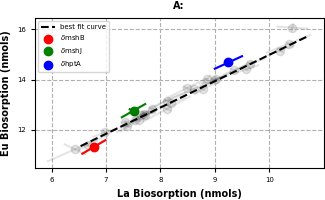

In [96]:
# Compares La and Yb biosortpion for wbpQ, wbnJ, and SO_3183 to rest to elucidate change in separation factor

fitting_strains = ['qwt', '1327t', '3385t', '4114t', '3189', '3190', '3191', 'qwt2', 
                   '3192', '4100', '4103', '4104', '4105', '4106', '4112', '3695', '2592', 
                   '4255', 'qwt3', '3175', '4799', '3183', '0456', '3988', '3099', '3145', 'qwt4']

plotting_strains = ['qwt', '1327t', '3385t', '4114t', '1203', '4685t', '3189', '3190', '3191', 'qwt2', 
                   '3192', '4100', '4103', '4104', '4105', '4106', '4112', '3695', '2592', 
                   '4255', 'qwt3', '3175', '4799', '3183', '0456', '3988', '3099', '3145', 'qwt4',]

normal_color = 'black'
labels_of_interest = ['4106', '4114t', '1327t']
names_of_interest = ['$\delta$mshB', '$\delta$mshJ', '$\delta$hptA']
colors_of_interest = ['r', 'g', 'b']

scen_labs = ['LL', 'LH', 'HL', 'HH']

# compares sep factors and biosorption
ree1 = 0 # That's La
ree2 = 1 # That's Eu
j = 1
c = 0.35
idx = 0
all_pts1 = []
all_pts2 = []

fig = plt.figure(figsize=figureSize)
ax = fig.gca()

for s in range(len(plotting_strains)):
    pts1 = bound_dic[plotting_strains[s]][j,:,ree1] * c
    pts2 = bound_dic[plotting_strains[s]][j,:,ree2] * c
    err1_xs, err1_ys, err2_xs, err2_ys = max_var_analysis(pts1, pts2)

    plt.scatter(np.mean(pts1), np.mean(pts2), color = normal_color, alpha = 0.1)
    plt.plot(err1_xs, err1_ys, '-', color = normal_color, alpha = 0.1)
    plt.plot(err2_xs, err2_ys, '-', color = normal_color, alpha = 0.1)
    if all_strains[s] in fitting_strains:
        all_pts1 += list(pts1)
        all_pts2 += list(pts2)

for s in range(len(labels_of_interest)):
    pts1 = bound_dic[labels_of_interest[s]][j,:,ree1] * c
    pts2 = bound_dic[labels_of_interest[s]][j,:,ree2] * c
    err1_xs, err1_ys, err2_xs, err2_ys = max_var_analysis(pts1, pts2)

    plt.scatter(np.mean(pts1), np.mean(pts2), label = names_of_interest[s], color = colors_of_interest[s])
    plt.plot(err1_xs, err1_ys, '-', color = colors_of_interest[s])
    plt.plot(err2_xs, err2_ys, '-', color = colors_of_interest[s])

best_fit, x_s, x_e = fit_line_curve(all_pts1, all_pts2, 0, 1)
pts_to_plot = np.linspace(x_s, x_e, 100)
plt.plot(pts_to_plot, np.poly1d(best_fit)(pts_to_plot), '--k', label='best fit curve')


plt.setp(ax.get_xticklabels(), fontsize=5)
plt.setp(ax.get_yticklabels(), fontsize=5)
ax.tick_params(axis='both', length=3)
plt.grid(linestyle='--')

leg = ax.legend(prop={"size":5})
#ax.set_title('$\delta$mshB, $\delta$mshJ, $\delta$hptA have La/Eu Affinity Changes at LH', fontsize=7, fontweight='bold')
ax.set_title('A:', fontsize=7, fontweight='bold')
ax.set_ylabel('Eu Biosorption (nmols)', fontsize=7, fontweight='bold')
ax.set_xlabel('La Biosorption (nmols)', fontsize=7, fontweight='bold')  
fig.tight_layout(pad=0.1)

plt.savefig(join(outputDir, 'panel_A_mshB_LH.svg'))
#plt.savefig(join(outputDir, 'mshB_LH.eps'))

<IPython.core.display.Javascript object>


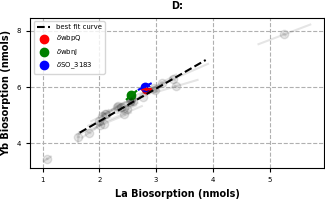

In [97]:
# Compares La and Yb biosortpion for wbpQ, wbnJ, and SO_3183 to rest to elucidate change in separation factor

fitting_strains = ['qwt', '1327t', '3385t', '4114t', '3189', '3190', '3191', 'qwt2', 
                   '3192', '4100', '4103', '4104', '4105', '4106', '4112', '3695', '2592', 
                   '4255', 'qwt3', '3175', '4799', '3183', '0456', '3988', '3099', '3145', 'qwt4']

plotting_strains = ['qwt', '1327t', '3385t', '4114t', '1203', '4685t', '3189', '3190', '3191', 'qwt2', 
                   '3192', '4100', '4103', '4104', '4105', '4106', '4112', '3695', '2592', 
                   '4255', 'qwt3', '3175', '4799', '3183', '0456', '3988', '3099', '3145', 'qwt4',]

normal_color = 'black'
labels_of_interest = ['3175', '4799', '3183']
names_of_interest = ['$\delta$wbpQ', '$\delta$wbnJ', '$\delta$SO_3183']
colors_of_interest = ['r', 'g', 'b']

scen_labs = ['LL', 'LH', 'HL', 'HH']

# compares sep factors and biosorption
ree1 = 0
ree2 = 2
j = 3
c = 0.35
idx = 0
all_pts1 = []
all_pts2 = []

fig = plt.figure(figsize=figureSize)
ax = fig.gca()

for s in range(len(plotting_strains)):
    pts1 = bound_dic[plotting_strains[s]][j,:,ree1] * c
    pts2 = bound_dic[plotting_strains[s]][j,:,ree2] * c
    err1_xs, err1_ys, err2_xs, err2_ys = max_var_analysis(pts1, pts2)

    plt.scatter(np.mean(pts1), np.mean(pts2), color = normal_color, alpha = 0.1)
    plt.plot(err1_xs, err1_ys, '-', color = normal_color, alpha = 0.1)
    plt.plot(err2_xs, err2_ys, '-', color = normal_color, alpha = 0.1)
    if all_strains[s] in fitting_strains:
        all_pts1 += list(pts1)
        all_pts2 += list(pts2)

for s in range(len(labels_of_interest)):
    pts1 = bound_dic[labels_of_interest[s]][j,:,ree1] * c
    pts2 = bound_dic[labels_of_interest[s]][j,:,ree2] * c
    err1_xs, err1_ys, err2_xs, err2_ys = max_var_analysis(pts1, pts2)

    plt.scatter(np.mean(pts1), np.mean(pts2), label = names_of_interest[s], color = colors_of_interest[s])
    plt.plot(err1_xs, err1_ys, '-', color = colors_of_interest[s])
    plt.plot(err2_xs, err2_ys, '-', color = colors_of_interest[s])

best_fit, x_s, x_e = fit_line_curve(all_pts1, all_pts2, 0, 1)
pts_to_plot = np.linspace(x_s, x_e, 100)
plt.plot(pts_to_plot, np.poly1d(best_fit)(pts_to_plot), '--k', label='best fit curve')

plt.setp(ax.get_xticklabels(), fontsize=5)
plt.setp(ax.get_yticklabels(), fontsize=5)
ax.tick_params(axis='both', length=3)
plt.grid(linestyle='--')

leg = ax.legend(prop={"size":5})
#ax.set_title('Polysacc. 1 has Enhanced Yb Biosorption in HH', fontsize=7, fontweight='bold')
ax.set_title('D:', fontsize=7, fontweight='bold')
ax.set_ylabel('Yb Biosorption (nmols)', fontsize=7, fontweight='bold')
ax.set_xlabel('La Biosorption (nmols)', fontsize=7, fontweight='bold')  
fig.tight_layout(pad=0.1)

plt.savefig(join(outputDir, 'panel_D_poly_sac_seps.svg'))
#plt.savefig(join(outputDir, 'poly_sac_seps.eps'))

<IPython.core.display.Javascript object>


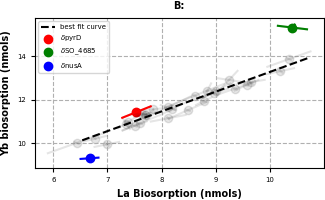

In [98]:
# Compares La and Yb biosortpion for wbpQ, wbnJ, and SO_3183 to rest to elucidate change in separation factor

fitting_strains = ['qwt', '1327t', '3385t', '4114t', '3189', '3190', '3191', 'qwt2', 
                   '3192', '4100', '4103', '4104', '4105', '4106', '4112', '3695', '2592', 
                   '4255', 'qwt3', '3175', '4799', '3183', '0456', '3988', '3099', '3145', 'qwt4']

normal_color = 'black'
labels_of_interest = ['2592', '4685t', '1203']
names_of_interest = ['$\delta$pyrD', '$\delta$SO_4685', '$\delta$nusA']
colors_of_interest = ['r', 'g', 'b', 'y', 'm']

scen_labs = ['LL', 'LH', 'HL', 'HH']

# compares sep factors and biosorption
ree1 = 0
ree2 = 2
j = 1
c = 0.35


fig = plt.figure(figsize=figureSize)
ax = fig.gca()


idx = 0
all_pts1 = []
all_pts2 = []
for s in range(len(plotting_strains)):
    pts1 = bound_dic[plotting_strains[s]][j,:,ree1] * c
    pts2 = bound_dic[plotting_strains[s]][j,:,ree2] * c
    err1_xs, err1_ys, err2_xs, err2_ys = max_var_analysis(pts1, pts2)

    plt.scatter(np.mean(pts1), np.mean(pts2), color = normal_color, alpha = 0.1)
    plt.plot(err1_xs, err1_ys, '-', color = normal_color, alpha = 0.1)
    plt.plot(err2_xs, err2_ys, '-', color = normal_color, alpha = 0.1)
    if all_strains[s] in fitting_strains:
        all_pts1 += list(pts1)
        all_pts2 += list(pts2)

for s in range(len(labels_of_interest)):
    pts1 = bound_dic[labels_of_interest[s]][j,:,ree1] * c
    pts2 = bound_dic[labels_of_interest[s]][j,:,ree2] * c
    err1_xs, err1_ys, err2_xs, err2_ys = max_var_analysis(pts1, pts2)

    plt.scatter(np.mean(pts1), np.mean(pts2), label = names_of_interest[s], color = colors_of_interest[s])
    plt.plot(err1_xs, err1_ys, '-', color = colors_of_interest[s])
    plt.plot(err2_xs, err2_ys, '-', color = colors_of_interest[s])

best_fit, x_s, x_e = fit_line_curve(all_pts1, all_pts2, 0, 1)
pts_to_plot = np.linspace(x_s, x_e, 100)
plt.plot(pts_to_plot, np.poly1d(best_fit)(pts_to_plot), '--k', label='best fit curve')

plt.setp(ax.get_xticklabels(), fontsize=5)
plt.setp(ax.get_yticklabels(), fontsize=5)
ax.tick_params(axis='both', length=3)
plt.grid(linestyle='--')

leg = ax.legend(prop={"size":5})
#ax.set_title('Several Genes Have Changes to Relative Affinity to La/Yb in ' + scen_labs[j], fontsize=7, fontweight='bold')
ax.set_title('B:', fontsize=7, fontweight='bold')
ax.set_ylabel('Yb biosorption (nmols)', fontsize=7, fontweight='bold')
ax.set_xlabel('La Biosorption (nmols)', fontsize=7, fontweight='bold')  
fig.tight_layout(pad=0.1)


plt.savefig(join(outputDir, 'panel_B_pyr_seps.svg'))
#plt.savefig(join(outputDir, 'pyr_seps.eps'))

<IPython.core.display.Javascript object>


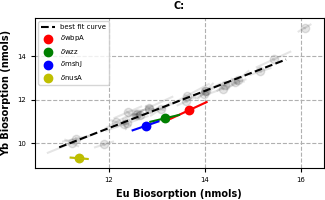

In [99]:
# Compares La and Yb biosortpion for wbpQ, wbnJ, and SO_3183 to rest to elucidate change in separation factor

fitting_strains = ['qwt', '1327t', '3385t', '4114t', '3189', '3190', '3191', 'qwt2', 
                   '3192', '4100', '4103', '4104', '4105', '4106', '4112', '3695', '2592', 
                   '4255', 'qwt3', '3175', '4799', '3183', '0456', '3988', '3099', '3145', 'qwt4']

normal_color = 'black'
labels_of_interest = ['3190', '3191', '4114t', '1203']
names_of_interest = ['$\delta$wbpA', '$\delta$wzz', '$\delta$mshJ', '$\delta$nusA']
colors_of_interest = ['r', 'g', 'b', 'y', 'm']

scen_labs = ['LL', 'LH', 'HL', 'HH']

fig = plt.figure(figsize=figureSize)
ax = fig.gca()

# compares sep factors and biosorption
ree1 = 1
ree2 = 2
j = 1
c = 0.35
idx = 0
all_pts1 = []
all_pts2 = []
for s in range(len(plotting_strains)):
    pts1 = bound_dic[plotting_strains[s]][j,:,ree1] * c
    pts2 = bound_dic[plotting_strains[s]][j,:,ree2] * c
    err1_xs, err1_ys, err2_xs, err2_ys = max_var_analysis(pts1, pts2)

    plt.scatter(np.mean(pts1), np.mean(pts2), color = normal_color, alpha = 0.1)
    plt.plot(err1_xs, err1_ys, '-', color = normal_color, alpha = 0.1)
    plt.plot(err2_xs, err2_ys, '-', color = normal_color, alpha = 0.1)
    if all_strains[s] in fitting_strains:
        all_pts1 += list(pts1)
        all_pts2 += list(pts2)

for s in range(len(labels_of_interest)):
    pts1 = bound_dic[labels_of_interest[s]][j,:,ree1] * c
    pts2 = bound_dic[labels_of_interest[s]][j,:,ree2] * c
    err1_xs, err1_ys, err2_xs, err2_ys = max_var_analysis(pts1, pts2)

    plt.scatter(np.mean(pts1), np.mean(pts2), label = names_of_interest[s], color = colors_of_interest[s])
    plt.plot(err1_xs, err1_ys, '-', color = colors_of_interest[s])
    plt.plot(err2_xs, err2_ys, '-', color = colors_of_interest[s])

best_fit, x_s, x_e = fit_line_curve(all_pts1, all_pts2, 0, 1)
pts_to_plot = np.linspace(x_s, x_e, 100)
plt.plot(pts_to_plot, np.poly1d(best_fit)(pts_to_plot), '--k', label='best fit curve')


plt.setp(ax.get_xticklabels(), fontsize=5)
plt.setp(ax.get_yticklabels(), fontsize=5)
ax.tick_params(axis='both', length=3)
plt.grid(linestyle='--')

leg = ax.legend(prop={"size":5})
#ax.set_title('Several Gene Knockouts have Eu/Yb changes at LH', fontsize=7, fontweight='bold')
ax.set_title('C:', fontsize=7, fontweight='bold')
ax.set_ylabel('Yb Biosorption (nmols)', fontsize=7, fontweight='bold')
ax.set_xlabel('Eu Biosorption (nmols)', fontsize=7, fontweight='bold')  
fig.tight_layout(pad=0.1)


plt.savefig(join(outputDir, 'panel_C_wbpA_LH.svg'))
#plt.savefig(join(outputDir, 'wbpA_LH.eps'))